In [ ]:
import nltk
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.spatial import distance
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer, WordNetLemmatizer


In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install datasets
import datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.3 MB/s eta 0:00:00


In [ ]:
Billsum_dataset = datasets.load_dataset("billsum", split="ca_test")
text = Billsum_dataset["text"][0]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

In [ ]:
Billsum_dataset["text"][0]

'The people of the State of California do enact as follows:\n\n\nSECTION 1.\nThe Legislature finds and declares all of the following:\n(a) (1) Since 1899 congressionally chartered veterans’ organizations have provided a valuable service to our nation’s returning service members. These organizations help preserve the memories and incidents of the great hostilities fought by our nation, and preserve and strengthen comradeship among members.\n(2) These veterans’ organizations also own and manage various properties including lodges, posts, and fraternal halls. These properties act as a safe haven where veterans of all ages and their families can gather together to find camaraderie and fellowship, share stories, and seek support from people who understand their unique experiences. This aids in the healing process for these returning veterans, and ensures their health and happiness.\n(b) As a result of congressional chartering of these veterans’ organizations, the United States Internal Reve

In [ ]:
 def rm_rrn(string):
    if isinstance(string, str):
        string = string.replace('\n\n', ' ')
        string = string.replace('\n', ' ')
        return string
    else:
        return string

text = rm_rrn(text)

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    return ' '.join(lemmatized_words)
corpus_lemmatized = []

In [ ]:
sentences = sent_tokenize(text)

In [ ]:
# Initialize stop words
stop_words = set(stopwords.words('english'))

In [ ]:
for i in range(len(sentences)):
    sen = re.sub('[^a-zA-Z]', " ", sentences[i])
    sen = sen.lower()
    sen = sen.split()
    sen = ' '.join([i for i in sen if i not in stop_words])

    sen_lemmatized = lemmatize_text(sen)
    corpus_lemmatized.append(sen_lemmatized)


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 6))  #Include unigram, bigram, and trigram
X = vectorizer.fit_transform(corpus_lemmatized)

tfidf_array = X.toarray()

In [ ]:
word2vec_model = Word2Vec(sentences=[word_tokenize(sent) for sent in corpus_lemmatized], vector_size=100)
print(word2vec_model)

Word2Vec<vocab=34, vector_size=100, alpha=0.025>


In [ ]:
word_embeddings = []
for sent in corpus_lemmatized:
    words = [word for word in word_tokenize(sent) if word in word2vec_model.wv]
    if words:
        sent_embedding = np.mean([word2vec_model.wv[word] for word in words], axis=0)
        word_embeddings.append(sent_embedding)
    else:
        word_embeddings.append(np.zeros(word2vec_model.vector_size))
word_embeddings_array = np.array(word_embeddings)
print(word_embeddings_array)

[[-4.42583114e-05  2.51976377e-03  4.51937877e-03 ... -6.02012873e-03
   7.11795990e-04 -4.69126226e-03]
 [-6.51174318e-03  1.68599782e-03 -1.99677699e-04 ...  5.90014562e-04
   1.62928854e-03  2.32208264e-03]
 [-9.06502642e-03  6.43605879e-03  4.84552421e-03 ...  2.27521919e-03
  -1.90733373e-03 -2.52124388e-04]
 ...
 [ 6.41425885e-03 -8.94597918e-03 -7.34298071e-03 ...  2.17736396e-03
   9.49960388e-03 -5.82131604e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.88868090e-03  1.98726635e-03  5.37246885e-03 ...  7.08779460e-03
   3.11292242e-04  8.77359416e-03]]


In [ ]:
num_samples_tfidf = tfidf_array.shape[0]
num_samples_embeddings = word_embeddings_array.shape[0]

# Adjust the arrays to have the same number of samples
if num_samples_tfidf > num_samples_embeddings:
    tfidf_array = tfidf_array[:num_samples_embeddings]  # Keep only the first num_samples_embeddings rows of tfidf_array
elif num_samples_tfidf < num_samples_embeddings:
    word_embeddings_array = word_embeddings_array[:num_samples_tfidf]

In [ ]:
if tfidf_array.shape[0] != word_embeddings_array.shape[0]:
    print("Error: Number of rows in TF-IDF array and word embeddings array do not match.")
else:
    # Concatenate TF-IDF array and word embeddings array
    combined_embeddings = np.concatenate((tfidf_array, word_embeddings_array), axis=1)
    print("Combined Embeddings shape:", combined_embeddings.shape)

Combined Embeddings shape: (43, 2598)


In [ ]:

print(combined_embeddings)



[[ 0.          0.          0.         ... -0.00602013  0.0007118
  -0.00469126]
 [ 0.          0.          0.         ...  0.00059001  0.00162929
   0.00232208]
 [ 0.          0.          0.         ...  0.00227522 -0.00190733
  -0.00025212]
 ...
 [ 0.          0.          0.         ...  0.00217736  0.0094996
  -0.00582132]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.00708779  0.00031129
   0.00877359]]


In [ ]:
sent_vectors = np.mean(combined_embeddings, axis=1)
print(sent_vectors)

[0.00175668 0.00314994 0.00300986 0.00256022 0.00357671 0.00220629
 0.00371192 0.00636824 0.00615276 0.00419935 0.00474832 0.00354335
 0.00459198 0.00235759 0.00257418 0.00332075 0.00257178 0.00198026
 0.00315916 0.00433777 0.00041035 0.00040279 0.         0.00175611
 0.00648839 0.00379065 0.00313542 0.0066388  0.0037606  0.00484012
 0.00287919 0.00315786 0.0033895  0.00192344 0.         0.00040279
 0.         0.00364757 0.00040279 0.         0.00040279 0.
 0.00275253]


In [ ]:

# Elbow method for finding the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=40, n_init=8)
    kmeans.fit(combined_embeddings)
    inertia.append(kmeans.inertia_)


In [ ]:
import matplotlib.pyplot as plt

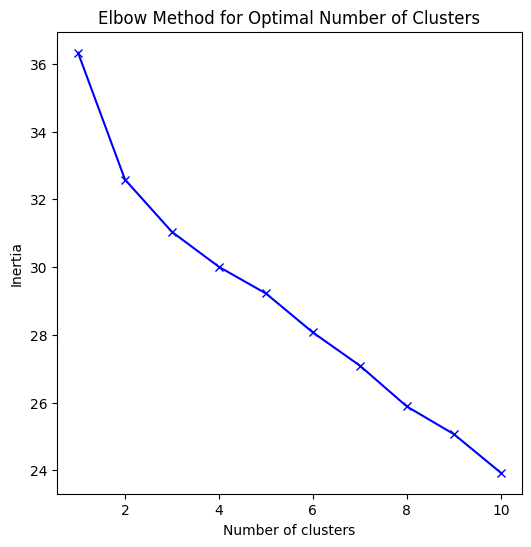

In [ ]:
# Plot the elbow graph
plt.figure(figsize=(6, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [ ]:
# Assuming the optimal number of clusters is selected based on the elbow method
optimal_clusters = int(input("Enter the optimal number of clusters based on the elbow plot: "))

Enter the optimal number of clusters based on the elbow plot: 3


In [ ]:
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=40, n_init=8)
y_kmeans = kmeans.fit_predict(combined_embeddings)


In [ ]:
my_list = []
for i in range(optimal_clusters):
    my_dict = {}
    for j in range(len(y_kmeans)):
        if y_kmeans[j] == i:
            my_dict[j] = distance.euclidean(kmeans.cluster_centers_[i], combined_embeddings[j])
    if my_dict:
        min_distance = min(my_dict.values())
        my_list.append(min(my_dict, key=my_dict.get))
    else:
        pass

In [ ]:
Billsum_dataset["summary"][0]

'Existing property tax law establishes a veterans’ organization exemption under which property is exempt from taxation if, among other things, that property is used exclusively for charitable purposes and is owned by a veterans’ organization.\nThis bill would provide that the veterans’ organization exemption shall not be denied to a property on the basis that the property is used for fraternal, lodge, or social club purposes, and would make specific findings and declarations in that regard. The bill would also provide that the exemption shall not apply to any portion of a property that consists of a bar where alcoholic beverages are served.\nSection 2229 of the Revenue and Taxation Code requires the Legislature to reimburse local agencies annually for certain property tax revenues lost as a result of any exemption or classification of property for purposes of ad valorem property taxation.\nThis bill would provide that, notwithstanding Section 2229 of the Revenue and Taxation Code, no a

In [ ]:
pip install rouge

In [ ]:
# Calculate ROUGE scores
from rouge import Rouge
predicted_summary = ' '.join([sentences[i] for i in sorted(my_list)])
actual_summary = Billsum_dataset["summary"][0]
rouge = Rouge()
scores = rouge.get_scores(predicted_summary, actual_summary)
scores

[{'rouge-1': {'r': 0.35051546391752575, 'p': 0.425, 'f': 0.38418078600657546},
  'rouge-2': {'r': 0.09090909090909091,
   'p': 0.12844036697247707,
   'f': 0.10646387347337703},
  'rouge-l': {'r': 0.26804123711340205, 'p': 0.325, 'f': 0.2937853057805867}}]

In [ ]:
print(predicted_summary)

SEC. 2. (a) All buildings, and so much of the real property on which the buildings are situated as may be required for the convenient use and occupation of the buildings, used exclusively for charitable purposes, owned by a veterans’ organization that has been chartered by the Congress of the United States, organized and operated for charitable purposes, and exempt from federal income tax as an organization described in Section 501(c)(19) of the Internal Revenue Code when the same are used solely and exclusively for the purpose of the organization, if not conducted for profit and no part of the net earnings of which inures to the benefit of any private individual or member thereof, shall be exempt from taxation.
